# Introduction to NLP Fundamentals with TensorFlow

NLP has the goal of derving information out of natural language (could be sequence text or speech)

Another common term for NLP problem is sequence to sequence (seq2seq).

## Check for GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d30b7ddf-b30b-7863-d9c0-58a3df4331db)


## Get the Helper Functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import the series of helper functions
from helper_functions import plot_loss_curves, compare_historys, unzip_data, create_tensorboard_callback

--2023-03-08 14:09:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-08 14:09:47 (87.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we are going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster)

See the original source here: https://www.kaggle.com/c/nlp-getting-started

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2023-03-08 14:09:52--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-03-08 14:09:52 (115 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
# Unzip the data
import zipfile

zip_ref = zipfile.ZipFile('nlp_getting_started.zip')
zip_ref.extractall()
zip_ref.close()

## Visualizing a Text data

In [ ]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Let's shuffle the train data
train_df_shuffled = train_df.sample(frac=1, random_state=43)
train_df_shuffled.head()

,id,keyword,location,text,target
1779,2554,crash,NaN,I feel that 'crash and burn' by Thomas Rhett f...,0
5097,7270,nuclear%20disaster,NaN,#Japan #Fukushima the most serious man made di...,1
1096,1585,bombed,New York,The U.S. bombed Hiroshima 70 years ago today. ...,1
4724,6719,lava,"Oklahoma, USA",Lava cakes are my fav.,0
191,270,ambulance,Karachi,Twelve feared killed in Pakistani air ambulanc...,1


In [ ]:
# Check the test data frame
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# How many examples of each class ?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# How many samples we have in total?
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Let's visualize some random training examples
import random

random_index = random.randint(0, len(train_df_shuffled) - 1)

for row in train_df_shuffled[['text', 'target']][random_index : random_index + 5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
Epilepsy claims another. Common and still a challenge to treat. Superhero toddler with rare epilepsy (Dravet) drowns http://t.co/VBo1tjNdps

---

Target: 0 (not real disaster)
Text:
The number of people denying climate change on the polar bear article makes me fear for the future of the US but also humanity in general.

---

Target: 0 (not real disaster)
Text:
@elgeotaofeeq that's not my take from his piece. Not putting that ambition in check will destroy the change we voted for the change we seek

---

Target: 1 (real disaster)
Text:
Wtf this mom just drowned her child?!

---

Target: 1 (real disaster)
Text:
Leeds fan.... rioting in Embra at a lower tier/ league cup final ... dee dum

---



## Splitting train data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                     train_df_shuffled["target"].to_numpy(),
                                                     test_size=0.1,  # Use 10 % of the training data as validation data.
                                                     random_state=43)

In [ ]:
# Check the length of the splited data
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# Check the first 10 senteces of train dataset
train_sentences[:10], train_labels[:10]

(array(['@dmassa5 Definite triple crown threat. Him and Harper both.',
        'Richmond police officer wounded suspect killed http://t.co/m9d2ElImZI',
        '@Sweet2Young -runs at her for setting my forest on fire and bites the shit out of her neck-',
        "Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Investigators and the families of those who were... http://t.co/pTeVY815mt",
        'Alabama home quarantined over possible #Ebola case: An ambulance sat outside the University of Alabama at\x89Û_ http://t.co/y2JT1aMyFJ',
        'I totally agree. They rape kill destroy and leave land desolate. Action needs to happen before the swarm swells. https://t.co/Twcds433YI',
        'The first piece of wreckage from the first-ever lost Boeing 777 which vanished back in early March along with the 239 people on board has',
        '#GRupdates Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released --&gt; http://t.co/fqcDPhccg7',
        "@Navista

## Converting Text into Numbers

When dealing with text problems, one of the first thing you will have to do before you can build a model is to convert your text to numbers.

There are few ways to do this:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned).

### Text Vectorization (tokenization)

In [ ]:
train_sentences[:5]

array(['@dmassa5 Definite triple crown threat. Him and Harper both.',
       'Richmond police officer wounded suspect killed http://t.co/m9d2ElImZI',
       '@Sweet2Young -runs at her for setting my forest on fire and bites the shit out of her neck-',
       "Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Investigators and the families of those who were... http://t.co/pTeVY815mt",
       'Alabama home quarantined over possible #Ebola case: An ambulance sat outside the University of Alabama at\x89Û_ http://t.co/y2JT1aMyFJ'],
      dtype=object)

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # How many words in the Vocabulary (automatically add <OOV> <out of vaocabulary>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,  # Create group of n-words?
                                    output_mode="int", # How to map tokens with numbers?
                                    output_sequence_length=None, # How long do you want your sequence to be?
                                    # pad_to_max_tokens=True
                                    )
# When None is used as a value in the above class it means that, we don't know the exact value,
# it has to figure out what should the value of the argument.

In [ ]:
len(train_sentences[0].split())

9

In [ ]:
# Find the average number of tokens (words in the training tweets)
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [ ]:
# Setup text vectorization variables
max_vocab_length = 10000 # Maximum number of words in our vocabulary
max_length = 15 # Maximum length of our sequences (e.g. how many words from a tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training data.
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There is a flood in our neighouring country."
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 72,   9,   3, 209,   4, 106,   1, 720,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training data and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original Sentence:\n{random_sentence} \
      \n\nVectorize Sentence:")
text_vectorizer([random_sentence])

Original Sentence:
IM GONNA GET NAKED AND SMOKE MY CIGARETTE someone call me radneck or is it just too hot in here       

Vectorize Sentence:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  32,  281,   50,    1,    7,  259,   13, 3124,  340,  402,   28,
        9402,   55,    9,   15]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all the unique words in the vocabulary
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in the vocabulary: {len(words_in_vocab)}")
print(f"Most common 5 words: {top_5_words}")
print(f"Least common 5 words: {bottom_5_words}")

Number of words in the vocabulary: 10000
Most common 5 words: ['', '[UNK]', 'the', 'a', 'in']
Least common 5 words: ['panther', 'pantalonesfuego', 'panoramic', 'panik', 'panics']


## Creating an Embedding

To make our embedding, we're going to use TensorFlow's embedding layer.
The parameters we care most about for our embedding layer:
* `input_dim` - the size of the vocabulary
* `output_dim` - the size of output embedding vector, for e.g. a value of 100 means each token get represented by a vector of 100 long
* `input_length` - length of the seqence being passed to the embedding layer.

In [ ]:
import tensorflow as tf

embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length, # input shape
                                      output_dim=128, # output shape
                                      input_length=max_length # how long each input is
                                      )
embedding

In [ ]:
# Get a random sentence from the train dataset
random_sentence = random.choice(train_sentences)
print(f"Original Sentence: \n{random_sentence} \
      \n\nEmbedding Sentence: ")
# Embed the random sentence (turn it into dense vector of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original Sentence: 
AngelRiveraLibÛ_ #Snowden 'may have' broken laws? Hurricane Katrina may have caused some damage. http://t.co/jAaWuiOvdc Without Snowden hÛ_       

Embedding Sentence: 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04725714,  0.0135316 , -0.04805836, ..., -0.00251811,
         -0.00813572,  0.03585092],
        [ 0.02514979, -0.01328935,  0.00532695, ..., -0.03202058,
          0.0067891 , -0.02554817],
        [ 0.00431206,  0.02206549,  0.04471424, ...,  0.01655917,
         -0.03687726, -0.02748772],
        ...,
        [ 0.00706207,  0.04029298,  0.00042448, ...,  0.01787818,
         -0.01464226,  0.04948557],
        [ 0.04725714,  0.0135316 , -0.04805836, ..., -0.00251811,
         -0.00813572,  0.03585092],
        [-0.01241431, -0.04746163,  0.03838683, ..., -0.0476271 ,
         -0.00444334,  0.01510975]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.04725714,  0.0135316 , -0.04805836, -0.04104303,  0.00586395,
         0.01838044,  0.04376988,  0.04594468,  0.00937068, -0.03697626,
         0.01083747,  0.0481359 ,  0.04692912, -0.02724798, -0.01500465,
         0.0385933 , -0.00958268,  0.01448024,  0.01379493,  0.04312141,
         0.02112   ,  0.00523774, -0.01620634,  0.00373272,  0.0222114 ,
        -0.011622  ,  0.00122593, -0.03667277, -0.00187268,  0.02150076,
        -0.00552012,  0.03042077,  0.01975833,  0.035119  ,  0.04546786,
         0.02963388,  0.02269376, -0.01529436, -0.01734424, -0.01358541,
         0.02780693,  0.0463762 ,  0.03322805, -0.04040899,  0.04672687,
         0.02678793, -0.00086402,  0.04937163, -0.00355165, -0.02342021,
        -0.0269918 , -0.02098044, -0.00091298,  0.0295274 , -0.03735161,
         0.01043546,  0.02916156, -0.03792988, -0.04890809,  0.0221546 ,
         0.00189079, -0.01415143, -0.01809128, -0.0275144 ,  0.04745333,
  

# Modelling a text dataset (running a series of experiments)

Now we've got a way to turn our sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there:
* Model 0: Navie Bayes (baseline), this is from scikit-learn ML map: https://www.scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-Forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrainind Feature Extraction (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of the training data

How we are going to approch all these ?

Use the standard steps in modelling:
* Create a model
* Compile the model
* Fit the model
* Evaluate our model

## Model 0: Getting a Baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for the future modelling experiments to build.

To create our baseline, we'll use Sklearn's multi-nomial Navie Bayers using the TF-IDF formula to convert our words to numbers.

> **Note:** It's common practice to use Non-Deep learning algorithms as a baseline because of their speed and then later using DL (deep leanring) to see if you can improve upon them.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeling
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # Convert word into numbers
    ('clr', MultinomialNB()) # Classifier model
])

# Fit the pipeline
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clr', MultinomialNB())])

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 82.68%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,

### Creating a function to evaluate the model performance

We could evaluate our model's prediction with different metrics every time, this will be cubersome and could be easily fixed with a function.

Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-Score

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate models Accuracy, Precision, Recall and F1-score
  """

  # Calculating models accuracy score
  model_accuracy = accuracy_score(y_true, y_pred)

  # Calcuate the model's precision, recall, f1-score
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

  model_results = {"Accuracy": model_accuracy,
                   "Precision": model_precision,
                   "Recall": model_recall,
                   "F1-score": model_f1}

  return model_results

In [ ]:
model_0_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)

model_0_results

{'Accuracy': 0.8267716535433071,
 'Precision': 0.8349072644989145,
 'Recall': 0.8267716535433071,
 'F1-score': 0.8228284651231783}

## Model 1: Building a simple deep learning model

In [ ]:
# Create a tensorboard callbacks (needs to create a new for each model)
# Already imported from the helper_functions.py file

# Create a directory to save the models logs
SAVE_DIR = "model_logs"

In [ ]:
# Build the model with functional api

inputs = tf.keras.layers.Input(shape=(1, ), dtype=tf.string) # Inputs are 1D strings
x = text_vectorizer(inputs) # turn the input text to numbers
x = embedding(x) # turn the numbers into embedding
x = tf.keras.layers.GlobalAveragePooling1D()(x) # Condense the feature vector for each token to one vector
# x = tf.keras.layers.GlobalMaxPooling1D()(x) # Getting less accuracy when using globalmaxpooling layer
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [ ]:
train_sentences.shape, train_labels.shape

((6851,), (6851,))

In [ ]:
# Fit the model
tf.config.run_functions_eagerly(True)
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                             experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20230308-141004
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


215/215 [==============================] - 20s 72ms/step - loss: 0.6146 - accuracy: 0.6841 - val_loss: 0.5157 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 8s 36ms/step - loss: 0.4449 - accuracy: 0.8186 - val_loss: 0.4401 - val_accuracy: 0.8136
Epoch 3/5
215/215 [==============================] - 8s 38ms/step - loss: 0.3496 - accuracy: 0.8596 - val_loss: 0.4247 - val_accuracy: 0.8176
Epoch 4/5
215/215 [==============================] - 8s 35ms/step - loss: 0.2873 - accuracy: 0.8907 - val_loss: 0.4285 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 8s 38ms/step - loss: 0.2400 - accuracy: 0.9105 - val_loss: 0.4440 - val_accuracy: 0.8163


In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 18ms/step - loss: 0.4440 - accuracy: 0.8163


[0.44402676820755005, 0.8162729740142822]

In [ ]:
# Make some predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:5]

24/24 [==============================] - 0s 10ms/step


array([[0.02583061],
       [0.13953494],
       [0.7631923 ],
       [0.1727438 ],
       [0.12684308]], dtype=float32)

In [ ]:
# Convert model prediction to labels formate
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 0., 0., 0.], dtype=float32)>

In [ ]:
# Calculate model 1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'Accuracy': 0.8162729658792651,
 'Precision': 0.8162985308654601,
 'Recall': 0.8162729658792651,
 'F1-score': 0.8149811810436448}

## Visualizing learned embeddings

In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Get the weight matrix of the embedding layer
# These are the numerical representation of each token in our training data, which have been learned for 5 epoch.
embed_weights = model_1.get_layer('embedding').get_weights()[0]
embed_weights

array([[ 0.04554347, -0.0168175 ,  0.04577935, ..., -0.00091681,
        -0.00926342,  0.05208159],
       [ 0.05392717,  0.01867692, -0.04323111, ..., -0.00655922,
        -0.01151055,  0.04329663],
       [-0.00135155, -0.01796185,  0.03997687, ...,  0.00084048,
        -0.02100269,  0.01948412],
       ...,
       [-0.08373158, -0.1080915 , -0.1158651 , ...,  0.10518916,
         0.04561795, -0.10790227],
       [ 0.05545923,  0.08256423,  0.10419822, ..., -0.07972115,
        -0.10163445,  0.12106621],
       [-0.10739355, -0.06784623, -0.03261863, ...,  0.04029394,
         0.11414879, -0.02722884]], dtype=float32)

In [ ]:
embed_weights[0].shape,

((128,),)

Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize.

To do so, tensorflow has a handy tool called projector: https://projector.tensorflow.org/

And tensorflow has an incredible guide on word embedding themselves https://www.tensorflow.org/tutorials/text/word_embeddings

In [ ]:
# Create embedding files (we've got this from the tensorflow word embedding documentation)
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# Downloading file from colab to our local machine to uplod it to the prjector
try:
  from google.colab import files
  files.download('vector.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

## Recurrent Neural Networks (RNNs)

RNN's is useful for sequence data.

The premise of a recurrent neural network is to use the representation of previous input to aid the representation of later input.

For resources visit the .ipynb file in docs.

## Model 2: LSTM

Long Short Term Memory (one of the most popular LSTM cells)

Our structure of RNN typically look like this:
```
Input (text) -> Tokenize -> Embedding -> Layers (RNN/dense) -> Output (label probability)
```

In [ ]:
# Create an LSTM model

inputs =  tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = tf.keras.layers.LSTM(units=64, return_sequences=True)(x) # When your are stacking RNN cells together, you need to set return sequences = True
# print(x.shape)
x = tf.keras.layers.LSTM(units=64)(x)
# print(x.shape)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
# print(x.shape)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [ ]:
# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
model_2.fit(train_sentences,
            y=train_labels,
            epochs=10,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                   "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230308-141128
Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


215/215 [==============================] - 15s 61ms/step - loss: 0.2196 - accuracy: 0.9238 - val_loss: 0.5613 - val_accuracy: 0.8018
Epoch 2/10
215/215 [==============================] - 16s 73ms/step - loss: 0.1570 - accuracy: 0.9415 - val_loss: 0.5604 - val_accuracy: 0.7874
Epoch 3/10
215/215 [==============================] - 13s 62ms/step - loss: 0.1274 - accuracy: 0.9533 - val_loss: 0.6106 - val_accuracy: 0.7874
Epoch 4/10
215/215 [==============================] - 13s 61ms/step - loss: 0.1012 - accuracy: 0.9609 - val_loss: 0.8950 - val_accuracy: 0.7730
Epoch 5/10
215/215 [==============================] - 13s 62ms/step - loss: 0.0823 - accuracy: 0.9651 - val_loss: 1.0876 - val_accuracy: 0.7782
Epoch 6/10
215/215 [==============================] - 13s 61ms/step - loss: 0.0707 - accuracy: 0.9689 - val_loss: 0.9451 - val_accuracy: 0.7703
Epoch 7/10
215/215 [==============================] - 13s 62ms/step - loss: 0.0686 - accuracy: 0.9714 - val_loss: 1.3331 - val_accuracy: 0.7822
Epo

In [ ]:
# Make prediction with the LSTM layer
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 16ms/step


array([[9.9094977e-06],
       [1.2469497e-03],
       [9.9942350e-01],
       [2.1385277e-02],
       [1.9771031e-05],
       [9.9996746e-01],
       [9.9999642e-01],
       [3.9462179e-02],
       [5.0945445e-03],
       [1.4047744e-04]], dtype=float32)

In [ ]:
# Convert model_2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 0., 0., 0.], dtype=float32)>

In [ ]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'Accuracy': 0.7847769028871391,
 'Precision': 0.7844579524270984,
 'Recall': 0.7847769028871391,
 'F1-score': 0.7830065655363883}

In [ ]:
baseline_results

{'Accuracy': 0.8267716535433071,
 'Precision': 0.8349072644989145,
 'Recall': 0.8267716535433071,
 'F1-score': 0.8228284651231783}

## Model 3: Gated Recurrent Unit (GRU) model

The GRU cell has the similar features to an LSTM cell but has less paramters.

In [ ]:
# Creating a GRU model using function api
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = tf.keras.layers.GRU(units=64, return_sequences=True)(x) # if you want to stack more than one layers of RNN then you need to set return_sequences=True
x = tf.keras.layers.GRU(units=64)(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
# x = tf.keras.layers.Dense(units=32, activation='relu')(x)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [ ]:
# Get the summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                       

In [ ]:
# Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230308-141351
Epoch 1/10
  1/215 [..............................] - ETA: 21s - loss: 0.6830 - accuracy: 0.6562

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


215/215 [==============================] - 13s 60ms/step - loss: 0.1439 - accuracy: 0.9437 - val_loss: 0.8178 - val_accuracy: 0.7743
Epoch 2/10
215/215 [==============================] - 13s 60ms/step - loss: 0.0682 - accuracy: 0.9717 - val_loss: 0.8103 - val_accuracy: 0.7940
Epoch 3/10
215/215 [==============================] - 13s 60ms/step - loss: 0.0512 - accuracy: 0.9785 - val_loss: 1.3218 - val_accuracy: 0.7480
Epoch 4/10
215/215 [==============================] - 13s 60ms/step - loss: 0.0417 - accuracy: 0.9799 - val_loss: 1.4222 - val_accuracy: 0.7769
Epoch 5/10
215/215 [==============================] - 13s 60ms/step - loss: 0.0449 - accuracy: 0.9788 - val_loss: 1.2330 - val_accuracy: 0.7756
Epoch 6/10
215/215 [==============================] - 13s 59ms/step - loss: 0.0389 - accuracy: 0.9800 - val_loss: 1.5089 - val_accuracy: 0.7743
Epoch 7/10
215/215 [==============================] - 13s 60ms/step - loss: 0.0398 - accuracy: 0.9804 - val_loss: 1.6019 - val_accuracy: 0.7782
Epo

In [ ]:
# Evaluating the model_3
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 15ms/step


array([[2.0407465e-06],
       [1.1220220e-03],
       [9.9982762e-01],
       [4.4506905e-03],
       [2.2445338e-06],
       [9.9998844e-01],
       [9.9999750e-01],
       [9.8412597e-01],
       [7.1317219e-04],
       [3.9924794e-06]], dtype=float32)

In [ ]:
# Converting pred_probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
# Calculating the results
model_3_results = calculate_results(y_true=val_labels,
                                  y_pred=model_3_preds)
model_3_results

{'Accuracy': 0.7624671916010499,
 'Precision': 0.7619598584401934,
 'Recall': 0.7624671916010499,
 'F1-score': 0.7621485394861824}

## Model 4: Bidirectional Recurrent Neural Network

In [ ]:
# Build the bidirectional rnn model
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64))(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_Bidirectional')

In [ ]:
# Get the summary of the model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 1)       

In [ ]:
# Compile the model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230308-141634
Epoch 1/10
  1/215 [..............................] - ETA: 23s - loss: 0.6873 - accuracy: 0.6562

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


215/215 [==============================] - 27s 127ms/step - loss: 0.0906 - accuracy: 0.9721 - val_loss: 1.4685 - val_accuracy: 0.7743
Epoch 2/10
215/215 [==============================] - 33s 152ms/step - loss: 0.0382 - accuracy: 0.9801 - val_loss: 1.3950 - val_accuracy: 0.7598
Epoch 3/10
215/215 [==============================] - 28s 130ms/step - loss: 0.0365 - accuracy: 0.9818 - val_loss: 1.6911 - val_accuracy: 0.7690
Epoch 4/10
215/215 [==============================] - 30s 140ms/step - loss: 0.0384 - accuracy: 0.9799 - val_loss: 1.2801 - val_accuracy: 0.7743
Epoch 5/10
215/215 [==============================] - 33s 154ms/step - loss: 0.0356 - accuracy: 0.9820 - val_loss: 1.9462 - val_accuracy: 0.7743
Epoch 6/10
215/215 [==============================] - 29s 137ms/step - loss: 0.0332 - accuracy: 0.9818 - val_loss: 1.8430 - val_accuracy: 0.7651
Epoch 7/10
215/215 [==============================] - 22s 101ms/step - loss: 0.0334 - accuracy: 0.9825 - val_loss: 1.7539 - val_accuracy: 0.7

In [ ]:
# Predicting the results of validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 23ms/step


array([[4.6790474e-06],
       [6.4523742e-02],
       [9.9990320e-01],
       [1.4869447e-01],
       [1.7679704e-04],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9889576e-01],
       [2.5094692e-02],
       [3.0438424e-04]], dtype=float32)

In [ ]:
# Getting the labels from the pred_probs
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'Accuracy': 0.7454068241469817,
 'Precision': 0.7460128223408694,
 'Recall': 0.7454068241469817,
 'F1-score': 0.7456634543248716}

## Convolutional Neural Network for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (width * height) ... however our text is 1D.

Previously we've used Conv2D for images but now we'll use Conv1D for text.

The typical structure of Conv1D model for sequences:


>Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typicall Conv1D + Polling) -> Outputs (class probability)

### Model 5: Connvolutonal1D model

In [ ]:
# Build the model 5 using conv1d layer
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(filters=32,
                           kernel_size=5,
                           activation='relu')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_Conv1D')

In [ ]:
# Get the summary of the model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_7 (Dense)             (None, 64)             

In [ ]:
# Compile the model
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20230308-142157
Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


215/215 [==============================] - 17s 53ms/step - loss: 0.1398 - accuracy: 0.9606 - val_loss: 0.9313 - val_accuracy: 0.7703
Epoch 2/10
215/215 [==============================] - 11s 50ms/step - loss: 0.0619 - accuracy: 0.9774 - val_loss: 1.0650 - val_accuracy: 0.7598
Epoch 3/10
215/215 [==============================] - 11s 51ms/step - loss: 0.0444 - accuracy: 0.9801 - val_loss: 1.3244 - val_accuracy: 0.7507
Epoch 4/10
215/215 [==============================] - 18s 84ms/step - loss: 0.0370 - accuracy: 0.9813 - val_loss: 1.4051 - val_accuracy: 0.7559
Epoch 5/10
215/215 [==============================] - 20s 92ms/step - loss: 0.0324 - accuracy: 0.9832 - val_loss: 1.6800 - val_accuracy: 0.7559
Epoch 6/10
215/215 [==============================] - 16s 77ms/step - loss: 0.0320 - accuracy: 0.9826 - val_loss: 1.7544 - val_accuracy: 0.7572
Epoch 7/10
215/215 [==============================] - 18s 84ms/step - loss: 0.0297 - accuracy: 0.9838 - val_loss: 1.9291 - val_accuracy: 0.7546
Epo

In [ ]:
# Getting the prediction probability
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 11ms/step


array([[1.4440724e-06],
       [3.5362783e-01],
       [9.9981934e-01],
       [6.8214894e-03],
       [3.1218908e-05],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.8545504e-01],
       [4.8136092e-03],
       [7.2337483e-05]], dtype=float32)

In [ ]:
# Getting the labels from the prediction probability
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
# Calculating the results
model_5_results = calculate_results(y_true=val_labels,
                                   y_pred=model_5_preds)
model_5_results

{'Accuracy': 0.7532808398950132,
 'Precision': 0.7534642139331912,
 'Recall': 0.7532808398950132,
 'F1-score': 0.7533673103249502}

In [ ]:
baseline_results

{'Accuracy': 0.8267716535433071,
 'Precision': 0.8349072644989145,
 'Recall': 0.8267716535433071,
 'F1-score': 0.8228284651231783}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder Model

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow's Hub Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       'When you use the universal sentence encoder on a sentence, it turn into numbers.'])
print(embed_samples[0][:50])

tf.Tensor(
[-0.06226405  0.03403164  0.02730554  0.0389852   0.00372002  0.07669322
  0.03140981  0.0015502   0.02862568 -0.02208256 -0.04204291 -0.00456659
  0.03574296  0.08897243 -0.01119766 -0.07899921  0.05447266 -0.03123199
  0.01803773 -0.05114342  0.00232029  0.03883025  0.05536261  0.03699803
 -0.07420377 -0.05175396 -0.00921101  0.0463687   0.06586583  0.02040838
 -0.04793089  0.00856488 -0.03255652 -0.04793032 -0.01942909 -0.06873745
  0.04916976 -0.00554924  0.04217354 -0.0440125  -0.01044143 -0.06868302
  0.0296879   0.07116184 -0.10232367 -0.0049542  -0.01504539  0.01735504
 -0.04146541 -0.01781352], shape=(50,), dtype=float32)


In [ ]:
# Create a Keras Layer using the Universal Sentence Encoder pre-trained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="universal_sentence_encoder")

# Create a Sequential Model
model_6 = tf.keras.models.Sequential([
    sentence_encoder_layer,
    # tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    # tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
], name="model_6_USE")

# Compile the model
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get the summary of the model_6
model_6.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_9 (Dense)             (None, 64)                32832     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_6_Universal_Sentence_Encoder")])

Saving TensorBoard log files to: model_logs/model_6_Universal_Sentence_Encoder/20230308-142552
Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


215/215 [==============================] - 31s 127ms/step - loss: 0.5157 - accuracy: 0.7778 - val_loss: 0.4147 - val_accuracy: 0.8228
Epoch 2/10
215/215 [==============================] - 22s 102ms/step - loss: 0.4180 - accuracy: 0.8126 - val_loss: 0.4039 - val_accuracy: 0.8307
Epoch 3/10
215/215 [==============================] - 18s 82ms/step - loss: 0.4048 - accuracy: 0.8205 - val_loss: 0.3959 - val_accuracy: 0.8268
Epoch 4/10
215/215 [==============================] - 12s 55ms/step - loss: 0.3951 - accuracy: 0.8264 - val_loss: 0.3964 - val_accuracy: 0.8255
Epoch 5/10
215/215 [==============================] - 12s 54ms/step - loss: 0.3885 - accuracy: 0.8288 - val_loss: 0.3954 - val_accuracy: 0.8294
Epoch 6/10
215/215 [==============================] - 12s 54ms/step - loss: 0.3818 - accuracy: 0.8302 - val_loss: 0.3932 - val_accuracy: 0.8386
Epoch 7/10
215/215 [==============================] - 12s 55ms/step - loss: 0.3746 - accuracy: 0.8362 - val_loss: 0.3975 - val_accuracy: 0.8373
E

In [ ]:
# Making predicting on the validation data
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 0s 19ms/step


array([[0.14404525],
       [0.5465077 ],
       [0.9098427 ],
       [0.11694467],
       [0.05691776],
       [0.9705067 ],
       [0.96211606],
       [0.29534945],
       [0.09919821],
       [0.10992841]], dtype=float32)

In [ ]:
# Getting the labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 0., 0., 0.], dtype=float32)>

In [ ]:
model_6_results = calculate_results(y_true=val_labels,
                                  y_pred=model_6_preds)
model_6_results

{'Accuracy': 0.8307086614173228,
 'Precision': 0.8303902729820846,
 'Recall': 0.8307086614173228,
 'F1-score': 0.8300210311620034}

## Model 7: TF Hub Pre-trained Universal Sentence Encoder (USE) but with 10% of training data

Transfer Learning really helps when you don't have a large dataset.

To see how our model perform on smaller dataset, let's replicate model_6 except we'll train on only 10% of the training dataset.

In [ ]:
# ## Making data splits like below leads to data leakage (model_7 trained on 10% data outperform model_6 trained on 100% data)
# ## DO NOT MAKE DATA SPLIT WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINIG SET

# # Create a subset of 10% training dataset
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=43)
# train_sentences_10_percent = train_10_percent["text"].values
# train_labels_10_percent = train_10_percent["target"].values
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [ ]:
# Making a better version of split so that there is no data leakage.
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_labels_10_percent)

685

In [ ]:
import numpy as np

pd.Series(np.array(train_labels_10_percent)).value_counts()

0    398
1    287
dtype: int64

In [ ]:
train_sentences_10_percent[:10]

array(['@dmassa5 Definite triple crown threat. Him and Harper both.',
       'Richmond police officer wounded suspect killed http://t.co/m9d2ElImZI',
       '@Sweet2Young -runs at her for setting my forest on fire and bites the shit out of her neck-',
       "Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Investigators and the families of those who were... http://t.co/pTeVY815mt",
       'Alabama home quarantined over possible #Ebola case: An ambulance sat outside the University of Alabama at\x89Û_ http://t.co/y2JT1aMyFJ',
       'I totally agree. They rape kill destroy and leave land desolate. Action needs to happen before the swarm swells. https://t.co/Twcds433YI',
       'The first piece of wreckage from the first-ever lost Boeing 777 which vanished back in early March along with the 239 people on board has',
       '#GRupdates Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released --&gt; http://t.co/fqcDPhccg7',
       "@Navista7 Steve t

In [ ]:
train_labels_10_percent[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [ ]:
# Check the number of targets in out subset dataset
# train_10_percent["target"].value_counts()

In [ ]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To re-create a model the sama as the previous model we've created we can use tf.keras.models.clone_model() methods in tensorflow.

In [ ]:
model_7 = tf.keras.models.clone_model(model_6)

# Compile the model
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get the summary of the model_7
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_9 (Dense)             (None, 64)                32832     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model on the 10 percent of the training data
model_7.history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_7_USE_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/model_7_USE_10_percent_correct_split/20230308-142920
Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


22/22 [==============================] - 4s 82ms/step - loss: 0.6713 - accuracy: 0.6438 - val_loss: 0.6423 - val_accuracy: 0.7546
Epoch 2/10
22/22 [==============================] - 2s 69ms/step - loss: 0.6026 - accuracy: 0.8161 - val_loss: 0.5790 - val_accuracy: 0.8136
Epoch 3/10
22/22 [==============================] - 2s 106ms/step - loss: 0.5293 - accuracy: 0.8146 - val_loss: 0.5164 - val_accuracy: 0.8097
Epoch 4/10
22/22 [==============================] - 2s 80ms/step - loss: 0.4677 - accuracy: 0.8219 - val_loss: 0.4778 - val_accuracy: 0.8097
Epoch 5/10
22/22 [==============================] - 2s 70ms/step - loss: 0.4240 - accuracy: 0.8292 - val_loss: 0.4575 - val_accuracy: 0.8136
Epoch 6/10
22/22 [==============================] - 2s 79ms/step - loss: 0.3946 - accuracy: 0.8453 - val_loss: 0.4498 - val_accuracy: 0.8163
Epoch 7/10
22/22 [==============================] - 1s 69ms/step - loss: 0.3704 - accuracy: 0.8467 - val_loss: 0.4475 - val_accuracy: 0.8110
Epoch 8/10
22/22 [=====

In [ ]:
# Making the prediction on the validation data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 0s 11ms/step


array([[0.08799914],
       [0.8736803 ],
       [0.8546545 ],
       [0.03155639],
       [0.12586436],
       [0.944098  ],
       [0.901183  ],
       [0.14634898],
       [0.06310846],
       [0.07170143]], dtype=float32)

In [ ]:
# Turn pred_probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 0., 0., 0.], dtype=float32)>

In [ ]:
# Results
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'Accuracy': 0.8070866141732284,
 'Precision': 0.8065780660591091,
 'Recall': 0.8070866141732284,
 'F1-score': 0.8062054787911597}

## Comparing the results of all the models

In [ ]:
all_model_results = pd.DataFrame({"0_baseline": model_0_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirection": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})

all_model_results = all_model_results.transpose()
all_model_results

,Accuracy,Precision,Recall,F1-score
0_baseline,0.826772,0.834907,0.826772,0.822828
1_simple_dense,0.816273,0.816299,0.816273,0.814981
2_lstm,0.784777,0.784458,0.784777,0.783007
3_gru,0.762467,0.761960,0.762467,0.762149
4_bidirection,0.745407,0.746013,0.745407,0.745663
5_conv1d,0.753281,0.753464,0.753281,0.753367
6_tf_hub_use_encoder,0.830709,0.830390,0.830709,0.830021
7_tf_hub_use_encoder_10_percent,0.807087,0.806578,0.807087,0.806205


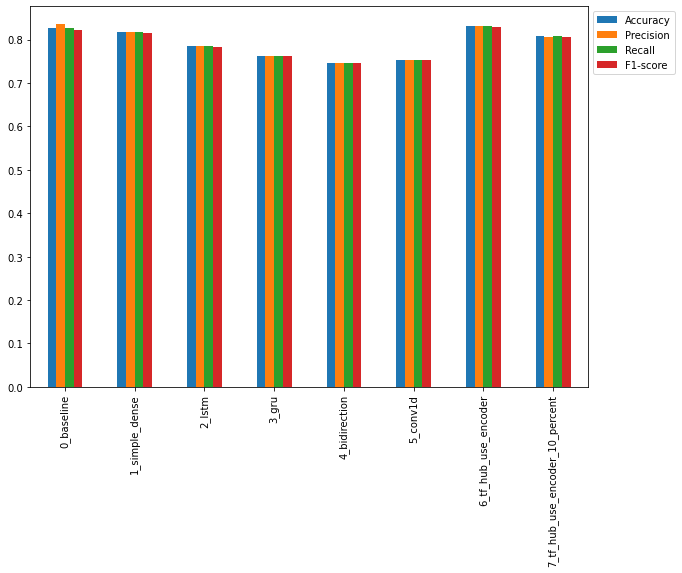

In [ ]:
# Plot and compare all of the model results
all_model_results.plotM.legend(bbox_to_anchor=(1.0, 1.0))

<AxesSubplot:>

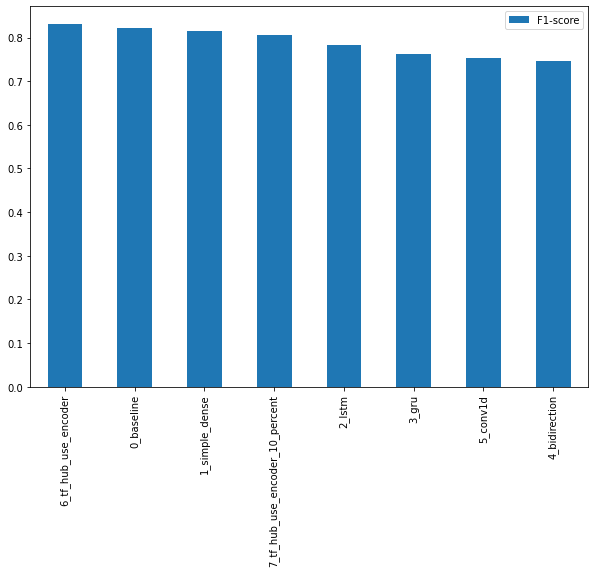

In [ ]:
# Sort the model results using f1-score
all_model_results[["F1-score"]].sort_values("F1-score", ascending=False).plot(kind="bar", figsize=(10, 7))

## Uploading our model's training log to tensorboard

In [ ]:
# View TensorBoard logs to transfer learning experiments
# Upload tensoboard dev record
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP modelling experiments" \
  --description "Comparing different models results on the kaggle's Tweets Disaster Classification dataset" \
  --one_shot # exit the uploader when the uploading is finishied

In [ ]:
# to get the previous experiment lists
!tensorboard dev list

In [ ]:
# If you want to delete an experiment from the tensorboard dev you can delete it by providing the experiment id
# !tensorboard dev delete --experiment_id <placeholder for experiment id >

TensorBoard is great for quick tracking experiments but for large scale experiments tracking options, check out Weights and Biases: https://wandb.ai/site

## Saving and loading a trained model

There are two main formats to save a tensorflow model
* The `HDF5` format
* The `SaveModel` format (this is default using tensorflow)

In [ ]:
# Save the TensorFlow Hub model to HDF5 format
model_6.save("model_6.h5")

In [ ]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# Evaluate the loaded model
loaded_model_6.evaluate(val_sentences, val_labels)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


24/24 [==============================] - 2s 56ms/step - loss: 0.3983 - accuracy: 0.8307


[0.3982662558555603, 0.8307086825370789]

In [ ]:
model_6_results

{'Accuracy': 0.8307086614173228,
 'Precision': 0.8303902729820846,
 'Recall': 0.8307086614173228,
 'F1-score': 0.8300210311620034}

Now, let's save to `SaveModel` format ...

In [ ]:
# Save TF Hub Universal Sentence Encoder model to SaveModel format (default)
model_6.save("model_6_SaveModel_format")

In [ ]:
# Load the SaveModel format
loaded_model_6_SaveModel_format = tf.keras.models.load_model("model_6_SaveModel_format")

In [ ]:
# Evalute the results of the model saved in SaveModel foramt
loaded_model_6_SaveModel_format.evaluate(val_sentences, val_labels)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


24/24 [==============================] - 1s 34ms/step - loss: 0.3983 - accuracy: 0.8307


[0.3982662558555603, 0.8307086825370789]

In [ ]:
model_6_results

{'Accuracy': 0.8307086614173228,
 'Precision': 0.8303902729820846,
 'Recall': 0.8307086614173228,
 'F1-score': 0.8300210311620034}

In [ ]:
# Downloading a file from colab
from google.colab import files
files.download("model_6_DaveModel_format")

## Find the most wrong examples

* If our best model still is not perfect, what examples is it getting most wrong?
* And of these wrong examples which one is getting *most* wrong (those with prediction probabilities clases to the opposite class)

For example if a sample should have a label of 0 but our models predicts a prediction probability of 0.999 (really close to 1) and vice-versa.

In [ ]:
# # Download a pretrained model from google storage
# !wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
# !unzip 08_model_6_USE_feature_extractor.zip

In [ ]:
# # Import previously trained model from Google Storage
# model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
# model_6_pretrained.evaluate(val_sentences, val_labels)

In [ ]:
# # Make prediction with the loaded model from Google Storage
# model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
# model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
# model_6_pretrained_preds[:10]

In [ ]:
val_sentences.shape, val_labels.shape, model_6_preds.shape, model_6_pred_probs.shape

((762,), (762,), TensorShape([762]), (762, 1))

In [ ]:
# Create a DataFrame with validation sentences validation labels and best performing model predictions labels + prediction probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_probs": model_6_pred_probs.reshape(len(model_6_pred_probs))})
val_df.head()

,text,target,pred,pred_probs
0,Stretcher brought out for Vampiro. Cut to comm...,0,0.0,0.144045
1,LONDON IS DROWNING AND IIII LIVE BY THE RIVEEE...,1,1.0,0.546508
2,#DroughtMonitor: Moderate or worse #drought ? ...,1,1.0,0.909843
3,I feel like death...holy molys ????????,0,0.0,0.116945
4,@Lenn_Len Probably. We are inundated with them...,0,0.0,0.056918


In [ ]:
# Find the wrong prediction and sort them by prediction probabilities in descending order
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_probs", ascending=False)
most_wrong.head(10) # false positive

,text,target,pred,pred_probs
35,We should all have a fire safety plan. RT @Mat...,0,1.0,0.983289
405,HereÛªs how media in Pakistan covered the cap...,0,1.0,0.954605
313,USW: 'The damage from abandoning the deal coul...,0,1.0,0.954348
215,County 911 Overload Prompts Use of Emergency P...,0,1.0,0.945303
229,@CNN the End of Times are upon us. Famine War ...,0,1.0,0.924966
470,09:13 PM: Hazardous Weather Outlook (http://t...,0,1.0,0.902787
585,@sabcnewsroom sabotage!I rule out structural f...,0,1.0,0.884029
78,Do you want to play a game?\nhttp://t.co/sQFp6...,0,1.0,0.854881
425,#TBT Remember that time Patrick Kane attacked ...,0,1.0,0.854156
753,Don't forget tragedy ?????????????? https://t....,0,1.0,0.846296


In [ ]:
most_wrong.tail(10) # false negative

,text,target,pred,pred_probs
527,It's alil twister at Tha end to! I was like oh...,1,0.0,0.089606
253,@Live_Workshop selfie at booth or riot Kappa,1,0.0,0.073984
25,going to redo my nails and watch behind the sc...,1,0.0,0.070723
409,#Reddit updates #content #policy promises to q...,1,0.0,0.069723
282,WIN: Lisowski whitewashes the Whirlwind 5-0 in...,1,0.0,0.065551
55,@lucysforsale funny cause my dumb ass was the ...,1,0.0,0.050311
124,Whereas Jez will obliterate the national debt ...,1,0.0,0.044155
451,Do you feel like you are sinking in low self-i...,1,0.0,0.041331
637,Man Currensy really be talkin that talk... I'd...,1,0.0,0.028414
272,Businesses are deluged with invoices. Make you...,1,0.0,0.025424


# Let's remind ourselves of the target labels:
* `0` = Not disaster
* `1` = disaster

In [ ]:
# Check the false positives (model predicted 1 when it should have 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_probs = row
  print(f"Target: {target}, Pred: {pred}, Porb: {pred_probs}")
  print(f"Text: \n{text}\n")
  print("-----\n")

Target: 0, Pred: 1.0, Porb: 0.9832890629768372
Text: 
We should all have a fire safety plan. RT @Matt_Kroschel: MOCK WILDFIRE near #Vail as agencies prepare for the worst. http://t.co/SWwyLRk0fv

-----

Target: 0, Pred: 1.0, Porb: 0.9546045064926147
Text: 
HereÛªs how media in Pakistan covered the capture of terrorist Mohammed Naved http://t.co/f7WqpCEkg2

-----

Target: 0, Pred: 1.0, Porb: 0.954348087310791
Text: 
USW: 'The damage from abandoning the deal could well create a new level of uncertainty...economic upheaval &amp; military unrest'

-----

Target: 0, Pred: 1.0, Porb: 0.9453033804893494
Text: 
County 911 Overload Prompts Use of Emergency Plan During July 4 Celebrations http://t.co/HXTUPrA5bc http://t.co/DqxKJibbKy

-----

Target: 0, Pred: 1.0, Porb: 0.9249656796455383
Text: 
@CNN the End of Times are upon us. Famine War Death Plague. The presence is growing stronger.

-----

Target: 0, Pred: 1.0, Porb: 0.9027869701385498
Text: 
09:13 PM:  Hazardous Weather Outlook (http://t.

In [ ]:
# Check the false negative (model predicted 0 when it should have 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_probs = row
  print(f"Target: {target}, Pred: {pred}, Porb: {pred_probs}")
  print(f"Text: \n{text}\n")
  print("-----\n")

Target: 1, Pred: 0.0, Porb: 0.08960603177547455
Text: 
It's alil twister at Tha end to! I was like oh nah ??

-----

Target: 1, Pred: 0.0, Porb: 0.07398363202810287
Text: 
@Live_Workshop selfie at booth or riot Kappa

-----

Target: 1, Pred: 0.0, Porb: 0.07072284817695618
Text: 
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

-----

Target: 1, Pred: 0.0, Porb: 0.0697234496474266
Text: 
#Reddit updates #content #policy promises to quarantine Û÷extremely offensiveÛª communities http://t.co/EHGtZhKAn4

-----

Target: 1, Pred: 0.0, Porb: 0.06555139273405075
Text: 
WIN: Lisowski whitewashes the Whirlwind 5-0 in round 2 of Shanghai Masters Quals! |  http://t.co/MLigPUHVOh #snooker http://t.co/TcS2Cd5y6y

-----

Target: 1, Pred: 0.0, Porb: 0.05031117424368858
Text: 
@lucysforsale funny cause my dumb ass was the young one to get n trouble the most lol

-----

Target: 1, Pred: 0.0, Porb: 0.044155463576316833
Text: 
Whereas Jez will obliterate the national debt 

In [ ]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## Making prediction on the test data and visualizing them

In [ ]:
# pred_test_data = model_6.predict(test_df["text"])

test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text: \n{test_sample}\n")
  print("-----\n")

1/1 [==============================] - 0s 43ms/step
Pred: 0, Prob: 0.38825809955596924
Text: 
Ppl living w/ HIV have been charged with aggravated assault and bioterrorism for things w/ low or no risk of transmission. #HIVIsNotaCrime

-----

1/1 [==============================] - 0s 43ms/step
Pred: 0, Prob: 0.1370754987001419
Text: 
@ClockworkHeart When I read it this morning I had  a Mrs White moment ('Flames on the side of my face...') GAH.

-----

1/1 [==============================] - 0s 41ms/step
Pred: 1, Prob: 0.7992774844169617
Text: 
#USGS M 1.9 - 15km E of Anchorage Alaska: Time2015-08-06 00:11:16 UTC2015-08-05 16:11:16 -08:00 at epicen... http://t.co/HkIiPyX5jL #SM

-----

1/1 [==============================] - 0s 45ms/step
Pred: 0, Prob: 0.036173850297927856
Text: 
100  1' MIX NEW FLAT DOUBLE SIDED LINERLESS BOTTLE CAPS YOU CHOOSE MIX FLATTENED - Full reÛ_ http://t.co/61fALvOCuK http://t.co/1MuTpFcgDL

-----

1/1 [==============================] - 0s 47ms/step
Pred: 0, Prob:

## The speed/score trade-off

In [ ]:
# Let's make a function to measure the time of prediction
import time

def pred_timer(model, samples):
  """
  Time how long the model take to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make prediction
  end_time = time.perf_counter() # get finish time
  total_time = end_time - start_time # calculate how long predictions took to make
  time_per_pred = total_time / len(samples)
  return total_time, time_per_pred


In [ ]:
# Calculate TF Hub USE Time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 11ms/step


(0.3669416229986382, 0.00048155068634991887)

In [ ]:
# Calculate Baseline model time per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model=model_0,
                                                              samples=val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.059598898000331246, 7.821377690332184e-05)

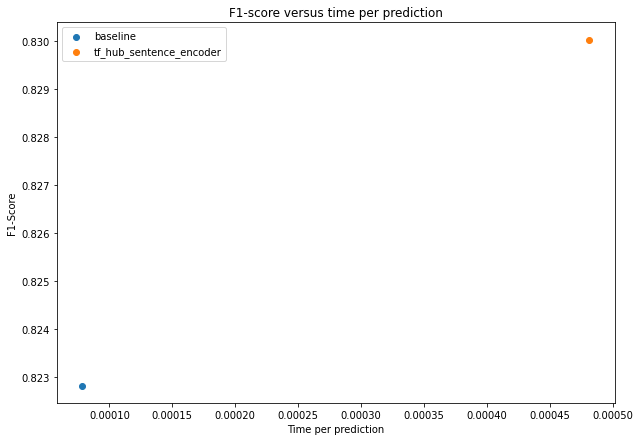

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, model_0_results["F1-score"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["F1-score"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");